In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)
from metatensor import load 
from mlelec.utils.twocenter_utils import _to_coupled_basis, _to_uncoupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks 

In [3]:
from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset
from mlelec.utils.twocenter_utils import fix_orbital_order

/home/nigam/miniconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
orbitals = {'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}, 
            'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]}}

In [5]:


def get_targets(dataset, device ="cpu", cutoff = None, target='fock'):
    if target.lower() == 'fock':
        matrices_negative = dataset._fock_realspace_negative_translations
    elif target.lower() == 'overlap':
        matrices_negative = dataset._overlap_realspace_negative_translations
    else: 
        raise ValueError('target must be fock or overlap')
    blocks = matrix_to_blocks(dataset, matrices_negative , device = 'cpu', cutoff = cutoff, all_pairs = True, target= target)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)

    blocks = blocks.keys_to_samples('cell_shift_a')
    blocks = blocks.keys_to_samples('cell_shift_b')
    blocks = blocks.keys_to_samples('cell_shift_c')

    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_a')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_b')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_c')
    return blocks , coupled_blocks

In [6]:
workdir = '/home/nigam/scratch/MAC/k-hamiltonian/'
root = f'{workdir}/examples/data/periodic/c2/'
ORBS = 'sto-3g'
START = 150
STOP = 174
frames = read(f'{root}/C2_174.extxyz', slice(START, STOP))
for f in frames: 
    f.pbc = True

kmesh = [8,8,1]
kfock = [np.load(f"{root}/results_C2_174_881/fock_{i}_881.npy") for i in range(START, STOP)]
kover = [np.load(f"{root}/results_C2_174_881/over_{i}_881.npy") for i in range(START, STOP)]
for ifr in range(len(frames)):
    for ik, k in enumerate(kfock[ifr]):
        kfock[ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) #### TODO <<
        kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frames[ifr], orbitals[ORBS]) #### TODO <<

dataset = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, fock_kspace = kfock, overlap_kspace = kover, device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

In [7]:
cutoff = 6
target_blocks_nc, target_coupled_blocks_nc = get_targets(dataset, cutoff = None)
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff)

target_blocks_nc_over, target_coupled_blocks_nc_over = get_targets(dataset, cutoff = None, target='overlap')
target_blocks_over, target_coupled_blocks_over = get_targets(dataset, cutoff = cutoff, target='overlap')


In [8]:
from mlelec.utils.pbc_utils import blocks_to_matrix
reconstructed_H = blocks_to_matrix(target_blocks, dataset)
reconstructed_S = blocks_to_matrix(target_blocks_over, dataset)

# reconstructed_H_nc = blocks_to_matrix(target_blocks_nc, dataset)
# reconstructed_S_nc = blocks_to_matrix(target_blocks_nc_over, dataset)

/tmp/ipykernel_196409/3947213395.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')
/tmp/ipykernel_196409/3947213395.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


IndexError: list index out of range

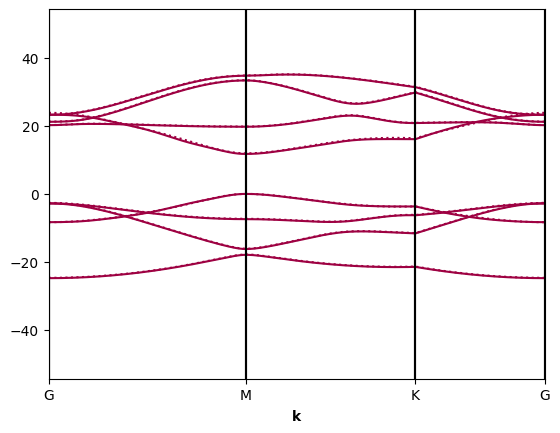

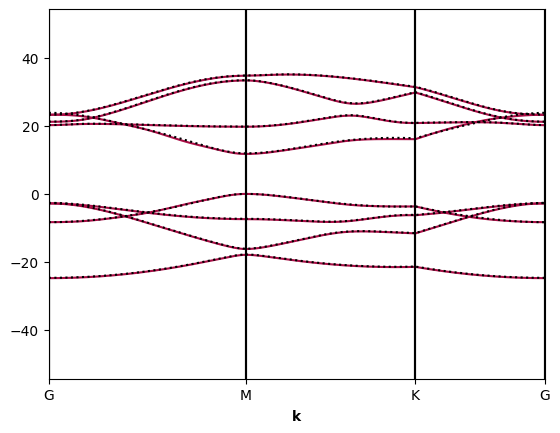

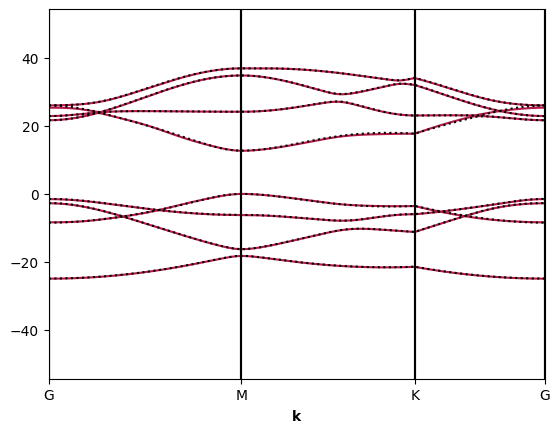

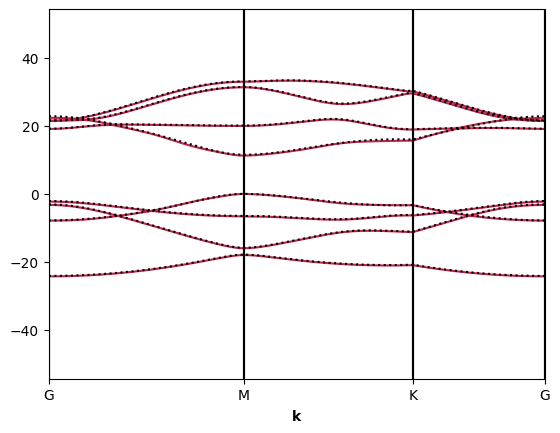

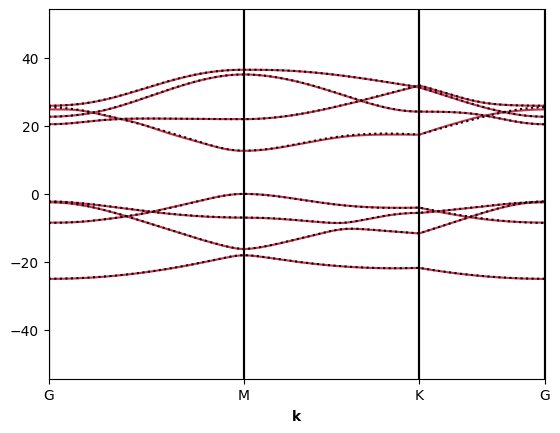

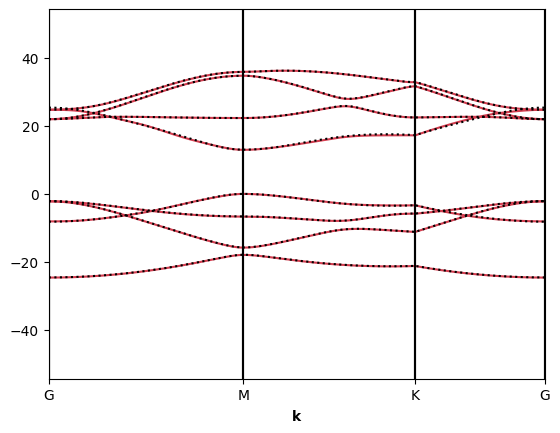

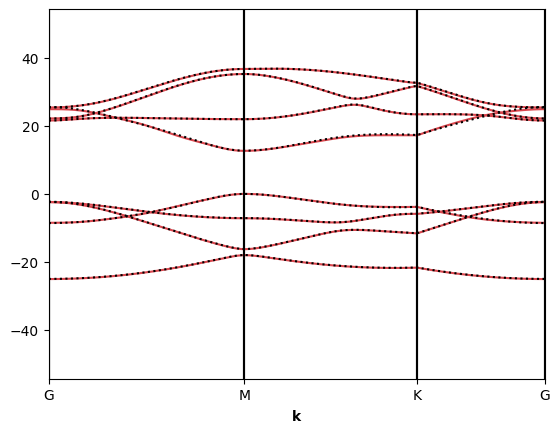

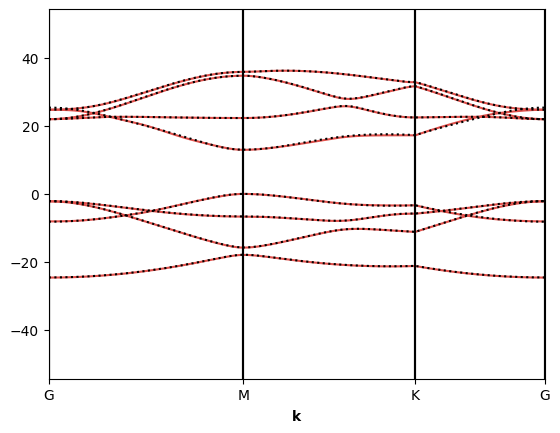

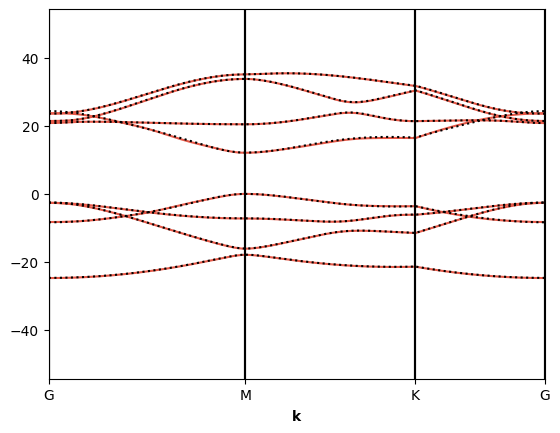

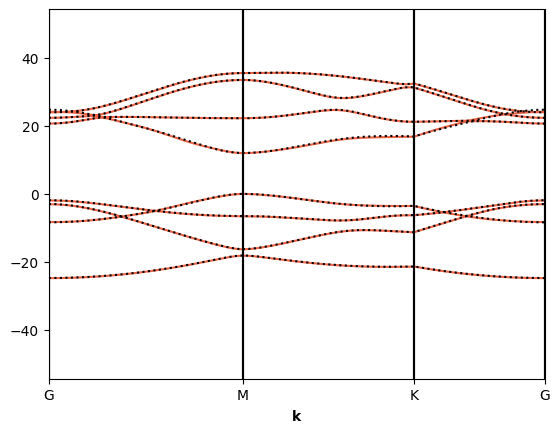

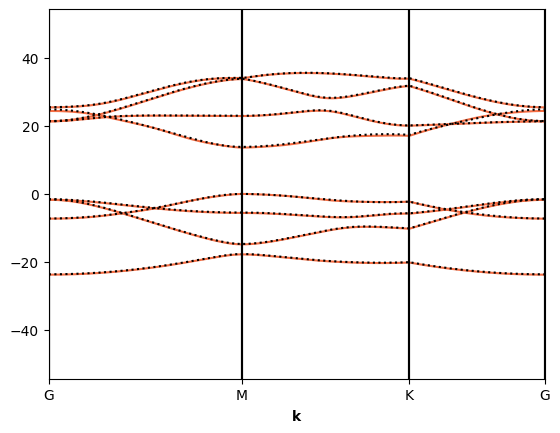

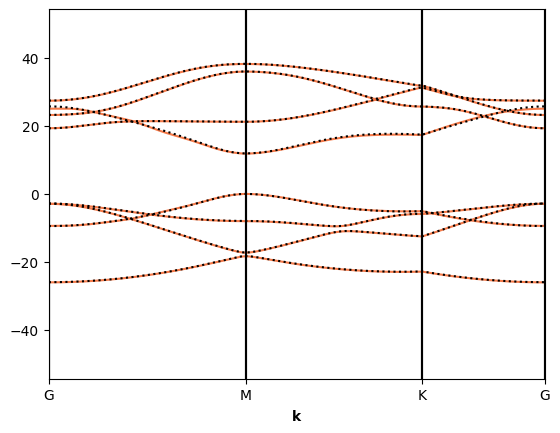

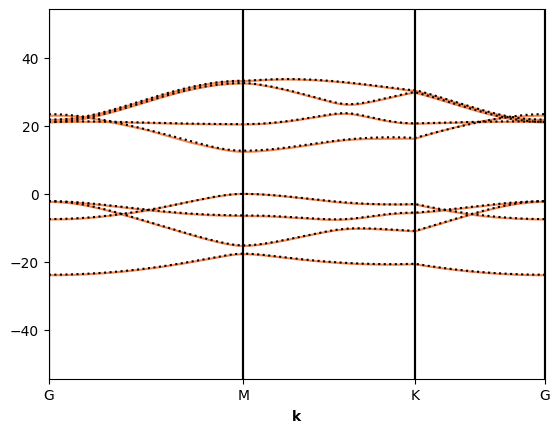

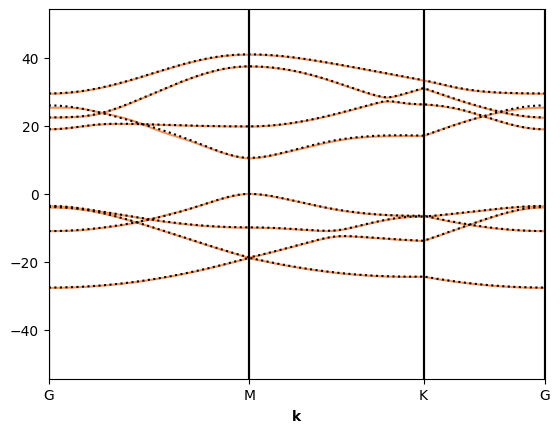

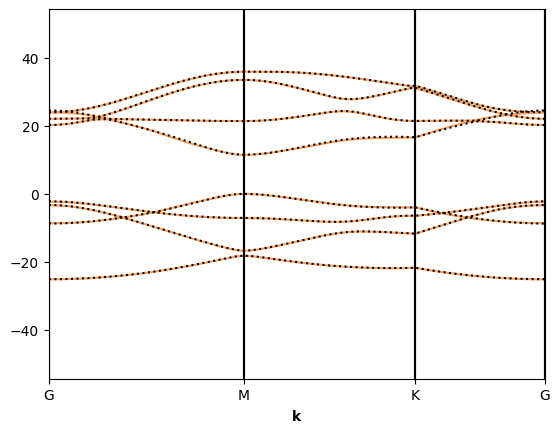

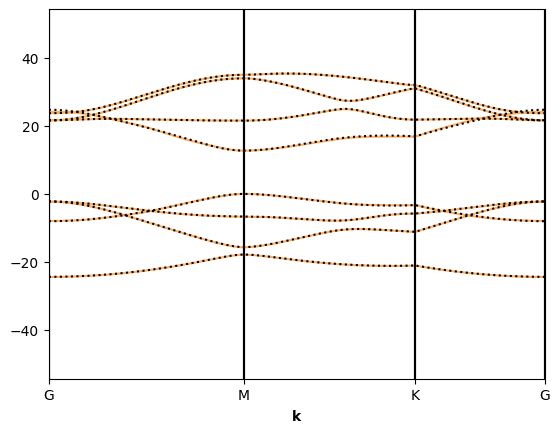

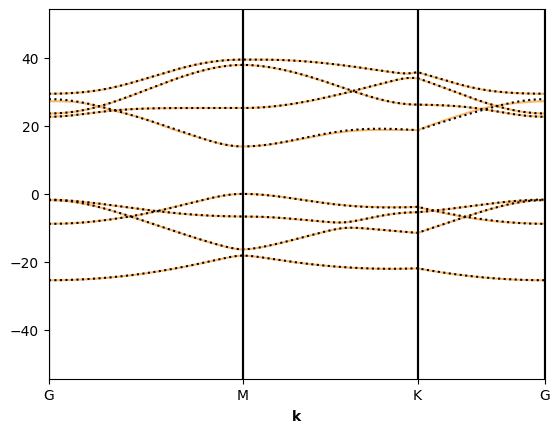

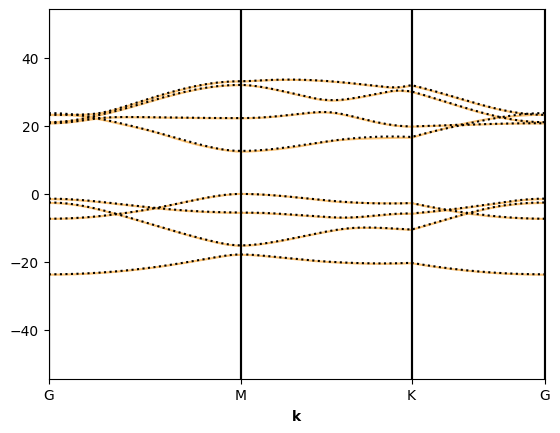

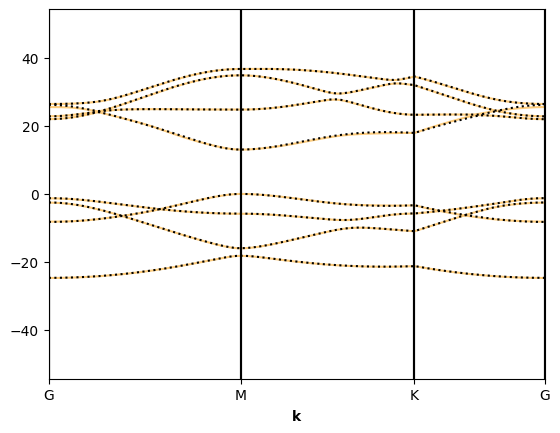

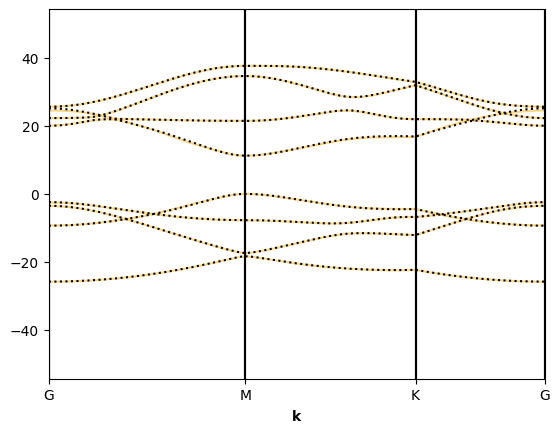

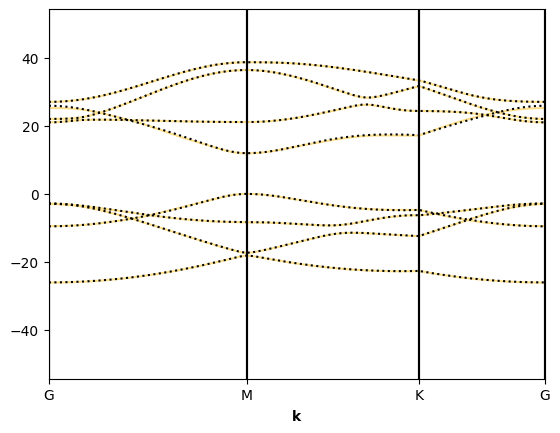

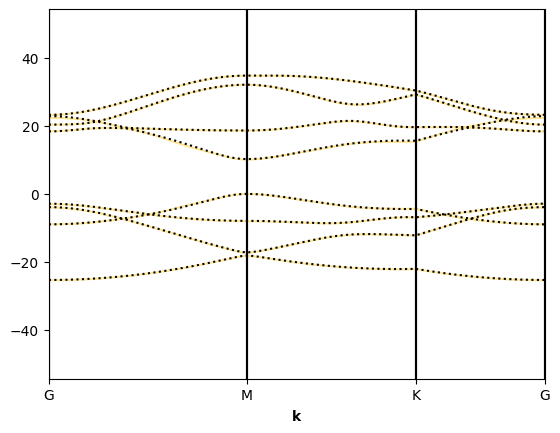

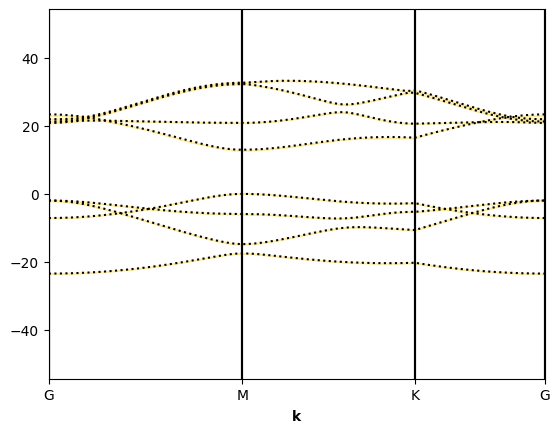

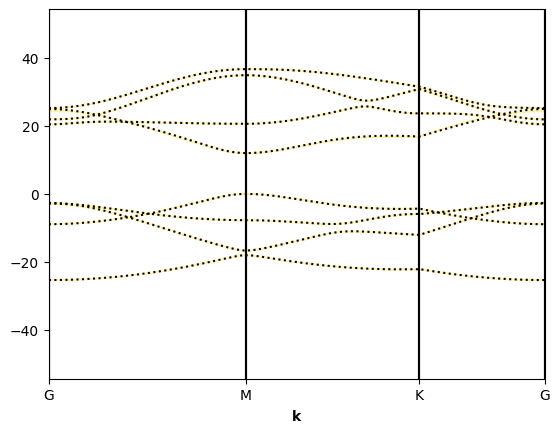

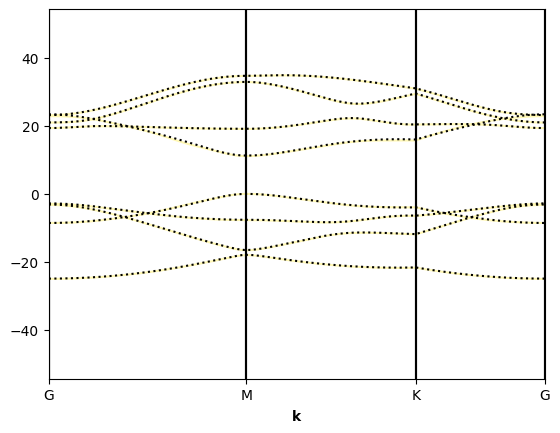

In [9]:
fig, ax = plt.subplots()

special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, -0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

cmap = matplotlib.cm.get_cmap('Spectral')


ifr = 0
frame = dataset.structures[ifr]
pyscf_cell = dataset.cells[ifr]
kmesh = dataset.kmesh[ifr]
kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
realfock = np.asarray(list(dataset.fock_realspace[0].values()))
realover = np.asarray(list(dataset.overlap_realspace[0].values()))

realfock_cutoff = np.asarray(list(reconstructed_H[0].values()))
realover_cutoff = np.asarray(list(reconstructed_S[0].values()))

ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, [8,8,1], special_symm = 'hexagonal', kpath = kpath, ax = ax, color = cmap(0))
ax, b = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, [8,8,1], special_symm = 'hexagonal', kpath = kpath, ax = ax, color = cmap(0), ls= ':')


nmax = 50
for ifr in range(0, nmax):
    frame = dataset.structures[ifr]
    pyscf_cell = dataset.cells[ifr]
    kmesh = dataset.kmesh[ifr]
    kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
    realfock = np.asarray(list(dataset.fock_realspace[ifr].values()))
    realover = np.asarray(list(dataset.overlap_realspace[ifr].values()))
    realfock_cutoff = np.asarray(list(reconstructed_H[ifr].values()))
    realover_cutoff = np.asarray(list(reconstructed_S[ifr].values()))
    fig, ax = plt.subplots()
    ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
                              kpath = kpath, ax=ax,color = cmap((ifr+1)/nmax))
    ax, b = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
                              kpath = kpath, ax = ax, color = 'k', ls = ':')



In [10]:
trainfrac = [1,5,10,25,50]

In [11]:
root = 'train_results/c2/cosmosrv_12.03/'
predictions = {tf:load(f'{root}/predictions_test_tf{tf}.npz').to(arrays='torch') for tf in trainfrac}

In [20]:
for tf, pred in predictions.items(): 
    blocks= []
    for k, b in pred.items():
        val = b.samples.values.copy()
        _to_subtract = val[:,0][0]
        val[:,0]-=_to_subtract # sets the target coupled blocks starting from 0 # asumming the structure idx in test blocks is sequential
        samples = Labels(b.samples.names, val)
        blocks.append(TensorBlock(values = b.values,
                                 samples = samples,
                                 components = b.components,
                                 properties = b.properties))
    pred = TensorMap(pred.keys, blocks)
    predictions[tf] = pred


In [42]:
def error_blocks(pred:TensorMap, target:TensorMap):
    assert pred.keys == target.keys
    block_loss = {}
    for (tk, tb), (pk,pb) in zip(target.items(), pred.items()):
        nsamples = len(tb.samples)
        ncomponents = len(tb.components)
        block_loss[tuple(tk)] = torch.norm(tb.values -pb.values)/(nsamples*ncomponents)    
    return block_loss
    
def error_matrix(pred:TensorMap, target:TensorMap):
    # assume passing coupled blocks for now 
    Hpred = blocks_to_matrix(_to_uncoupled_basis(target), dataset)
    Htarget = blocks_to_matrix(_to_uncoupled_basis(pred), dataset)
    assert len(Hpred) == len(Htarget)
    loss = 0
    
    for ifr in range(len(Hpred)):
        ntranslations = len(Hpred[ifr])
        for T,pred_mat in Hpred[ifr].items():
            assert pred_mat.shape[0] == pred_mat.shape[1]
            nelements = pred_mat.shape[0]
            loss += torch.norm(pred_mat - Htarget[ifr][T]) /(nelements*ntranslations)
    return loss 

In [43]:
block_loss = {}
matrix_loss = {}
for tf in predictions:
    block_loss[tf] = error_blocks(predictions[tf], target_coupled_blocks)
    matrix_loss[tf] = error_matrix(predictions[tf], target_coupled_blocks)

tensor([[-8.8327e+01, -2.3792e+01,  3.3217e-03, -8.4704e-15,  1.6741e-03,
         -8.0727e-04, -2.8367e+00,  4.7167e+00, -1.5056e-15, -8.0685e-02],
        [-2.3792e+01, -1.2742e+01,  1.5336e-01, -1.2640e-14,  7.4377e-02,
         -2.8367e+00, -4.6455e+00,  4.4097e+00,  5.9704e-15, -7.3183e-02],
        [ 3.3217e-03,  1.5336e-01, -3.2154e+00,  1.4912e-14, -3.1634e-02,
         -4.7167e+00, -4.4097e+00,  2.4580e+00,  1.8439e-15, -6.9762e-02],
        [-8.4704e-15, -1.2640e-14,  1.4912e-14, -8.8372e-01,  8.5549e-15,
          1.2204e-15, -6.4855e-15,  1.5971e-15, -1.5973e+00,  2.7755e-15],
        [ 1.6741e-03,  7.4377e-02, -3.1634e-02,  8.5549e-15, -3.3248e+00,
          8.0685e-02,  7.3183e-02, -6.9762e-02,  1.0244e-15, -1.3794e+00],
        [-8.0727e-04, -2.8367e+00, -4.7167e+00,  1.2204e-15,  8.0685e-02,
         -8.8327e+01, -2.3792e+01, -3.3217e-03,  1.2905e-15, -1.6741e-03],
        [-2.8367e+00, -4.6455e+00, -4.4097e+00, -6.4855e-15,  7.3183e-02,
         -2.3792e+01, -1.2742e+0

In [ ]:
block_loss

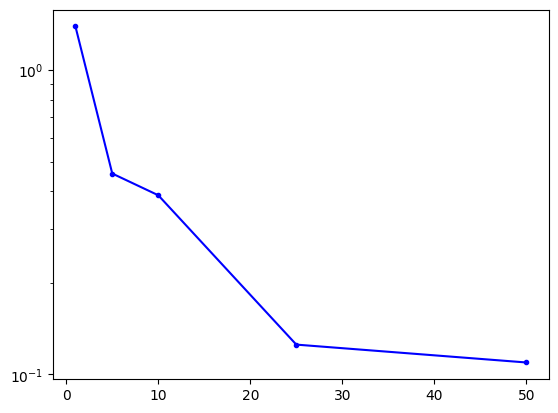

In [48]:
plt.plot(trainfrac, matrix_loss.values(), 'b-')
plt.plot(trainfrac, matrix_loss.values(), 'b.', label= 'Test')
plt.yscale('log')

plt.plot(trainfrac, )

## BN

## Graphene variety 

## Equivariance test 